In [ ]:
!pip install pandas
!pip install nltk
!pip install datasets
!pip install transformers
!pip install sentence-transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 9.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
from transformers import T5Tokenizer, T5ForConditionalGeneration
from sentence_transformers import SentenceTransformer
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr


In [ ]:
# prompt: drive mount

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
file_path = '/content/drive/MyDrive/NLP project/augmented_dataset_with_meaningless_answers_and_scores.csv'  # Adjust path
data = pd.read_csv(file_path)

print("First 5 rows of the dataset:")
print(data.head())

print("\nMissing values in each column:")
print(data.isnull().sum())


First 5 rows of the dataset:
   question_id                                           question  \
0            1          What is an algorithm in computer science?   
1            2   Explain the purpose of recursion in programming.   
2            3  What is the difference between a compiler and ...   
3            4  Describe the concept of object-oriented progra...   
4            5  What is the significance of data structures in...   

                                        ideal_answer  \
0  An algorithm in computer science is a step-by-...   
1  Recursion is a programming concept where a fun...   
2  A compiler translates the entire code of a hig...   
3  Object-oriented programming is a paradigm that...   
4  Data structures are fundamental in programming...   

                                    student_1_answer  \
0  An algorithm is a set of instructions that a c...   
1  Recursion is a powerful programming technique ...   
2  Compilers and interpreters differ fundamentall..

In [ ]:
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
def preprocess_text(text):
    text = text.lower()  # Case folding
    words = word_tokenize(text)  # Tokenization
    words = [word for word in words if word not in stop_words]  # Stopword removal
    words = [lemmatizer.lemmatize(word) for word in words]  # Lemmatization
    return ' '.join(words)


In [ ]:
columns_to_clean = ['ideal_answer', 'student_1_answer', 'student_2_answer', 'student_3_answer', 'student_4_answer']
for col in columns_to_clean:
    data[f'{col}_cleaned'] = data[col].apply(preprocess_text)

# Save cleaned data
cleaned_file_path = '/content/drive/MyDrive/NLP project/cleaned_dataset.csv'
data.to_csv(cleaned_file_path, index=False)
print(f"Cleaned data saved to: {cleaned_file_path}")


Cleaned data saved to: /content/drive/MyDrive/NLP project/cleaned_dataset.csv


In [ ]:
# prompt: print 5 rows cleaned

print(data.head())


   question_id                                           question  \
0            1          What is an algorithm in computer science?   
1            2   Explain the purpose of recursion in programming.   
2            3  What is the difference between a compiler and ...   
3            4  Describe the concept of object-oriented progra...   
4            5  What is the significance of data structures in...   

                                        ideal_answer  \
0  An algorithm in computer science is a step-by-...   
1  Recursion is a programming concept where a fun...   
2  A compiler translates the entire code of a hig...   
3  Object-oriented programming is a paradigm that...   
4  Data structures are fundamental in programming...   

                                    student_1_answer  \
0  An algorithm is a set of instructions that a c...   
1  Recursion is a powerful programming technique ...   
2  Compilers and interpreters differ fundamentall...   
3  Object-oriented progr

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=5)
tfidf_ideal = tfidf_vectorizer.fit_transform(data['ideal_answer_cleaned'])

# Transform all student answers
tfidf_student_answers = {}
for i in range(1, 5):
    tfidf_student_answers[i] = tfidf_vectorizer.transform(data[f'student_{i}_answer_cleaned'])


In [ ]:
n_topics = 5
lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda_ideal = lda_model.fit_transform(tfidf_ideal)

# Compute LDA topic distributions and similarities
lda_scores = {}
for i in range(1, 5):
    lda_student = lda_model.transform(tfidf_student_answers[i])
    lda_scores[i] = [cosine_similarity([lda_ideal[j]], [lda_student[j]])[0][0] for j in range(len(data))]
    data[f'lda_score_{i}'] = lda_scores[i]

# Print LDA topics
n_top_words = 10
print("\nTop words for each LDA topic:")
for topic_idx, topic in enumerate(lda_model.components_):
    print(f"Topic #{topic_idx}: {[tfidf_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-n_top_words - 1:-1]]}")



Top words for each LDA topic:
Topic #0: ['method', 'class', 'key', 'interface', 'encryption', 'ensuring', 'public', 'private', 'message', 'communication']
Topic #1: ['programming', 'code', 'software', 'like', 'security', 'container', 'tool', 'development', 'application', 'involves']
Topic #2: ['class', 'type', 'behavior', 'variable', 'code', 'instance', 'method', 'function', 'package', 'python']
Topic #3: ['data', 'system', 'memory', 'server', 'network', 'resource', 'storage', 'like', 'device', 'user']
Topic #4: ['learning', 'machine', 'data', 'model', 'processing', 'neural', 'used', 'blockchain', 'ai', 'function']


In [ ]:
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
sbert_scores = {}
for i in range(1, 5):
    sbert_scores[i] = [
        cosine_similarity(
            [sbert_model.encode(data['ideal_answer'][j])],
            [sbert_model.encode(data[f'student_{i}_answer'][j])]
        )[0][0] for j in range(len(data))
    ]
    data[f'sbert_score_{i}'] = sbert_scores[i]


In [ ]:
# prompt: print 5 rows of sbert

print(data[['sbert_score_1', 'sbert_score_2', 'sbert_score_3', 'sbert_score_4']].head())

   sbert_score_1  sbert_score_2  sbert_score_3  sbert_score_4
0       0.882576       0.848898       0.645084       0.827093
1       0.919060       0.888490       0.664718       0.409479
2       0.798927       0.748918       0.710924       0.593951
3       0.868823       0.851624       0.724367       0.831806
4       0.929135       0.879046       0.730788       0.776703


In [ ]:
t5_tokenizer = T5Tokenizer.from_pretrained("t5-small")
t5_model = T5ForConditionalGeneration.from_pretrained("t5-small")
def generate_t5_similarity_batch(ideal_answers, student_answers, batch_size=8):
    t5_similarities = []
    for start in range(0, len(ideal_answers), batch_size):
        end = min(start + batch_size, len(ideal_answers))
        input_texts = [f"generate answer: {text}" for text in ideal_answers[start:end]]
        inputs = t5_tokenizer(input_texts, return_tensors="pt", padding=True, truncation=True, max_length=512)
        with torch.no_grad():
            outputs = t5_model.generate(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'])
        decoded_outputs = [t5_tokenizer.decode(output, skip_special_tokens=True) for output in outputs]
        for generated, student in zip(decoded_outputs, student_answers[start:end]):
            t5_similarities.append(cosine_similarity(
                [sbert_model.encode(generated)],
                [sbert_model.encode(student)]
            )[0][0])
    return t5_similarities

t5_scores = {}
for i in range(1, 5):
    t5_scores[i] = generate_t5_similarity_batch(
        data['ideal_answer'].tolist(), data[f'student_{i}_answer'].tolist()
    )
    data[f't5_score_{i}'] = t5_scores[i]


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
#print 5 rows of t5

print(data[['t5_score_1', 't5_score_2', 't5_score_3', 't5_score_4']].head())

   t5_score_1  t5_score_2  t5_score_3  t5_score_4
0    0.594123    0.549685    0.489240    0.525760
1    0.776676    0.778425    0.640318    0.390484
2    0.543138    0.576012    0.531072    0.518331
3    0.791944    0.752086    0.677564    0.717654
4    0.068515   -0.019436    0.005069    0.048803


In [ ]:
for i in range(1, 5):
    data[f'final_score_{i}'] = (
        data[f'lda_score_{i}'] + data[f'sbert_score_{i}'] + data[f't5_score_{i}']
    ) / 3

final_file_path = '/content/drive/MyDrive/NLP project/final_scores_dataset_with_student4.csv'
data.to_csv(final_file_path, index=False)
print(f"Final scores dataset saved to: {final_file_path}")


Final scores dataset saved to: /content/drive/MyDrive/NLP project/final_scores_dataset_with_student4.csv


In [ ]:
#print 5 rows of final

print(data[['final_score_1', 'final_score_2', 'final_score_3', 'final_score_4']].head())

   final_score_1  final_score_2  final_score_3  final_score_4
0       0.600427       0.775448       0.443077       0.762196
1       0.815487       0.768514       0.511858       0.501596
2       0.764512       0.681825       0.495526       0.426917
3       0.827614       0.795737       0.774437       0.847977
4       0.662637       0.617461       0.573921       0.329293


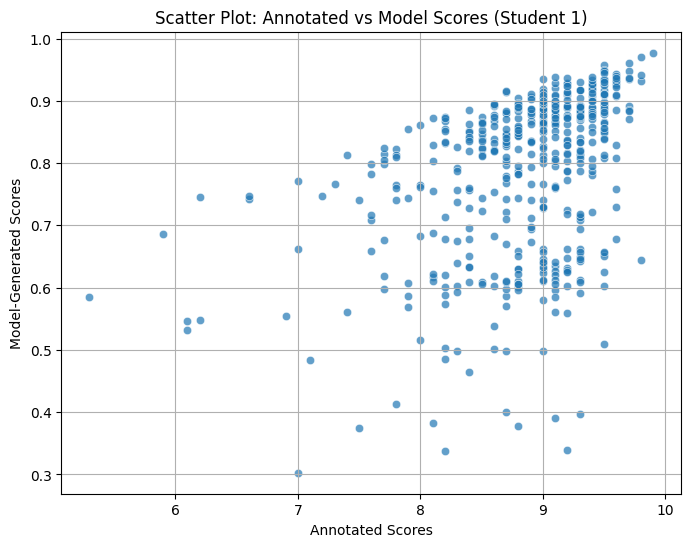

Pearson Correlation for Student 1: 0.4159 (p-value: 0.0000)


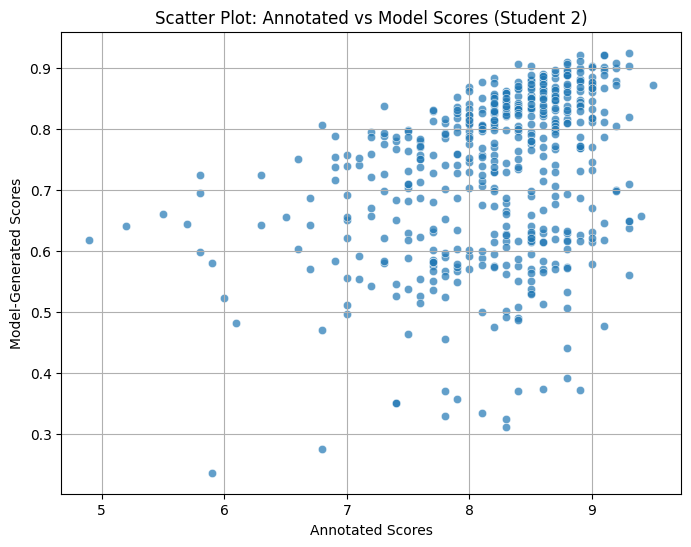

Pearson Correlation for Student 2: 0.3351 (p-value: 0.0000)


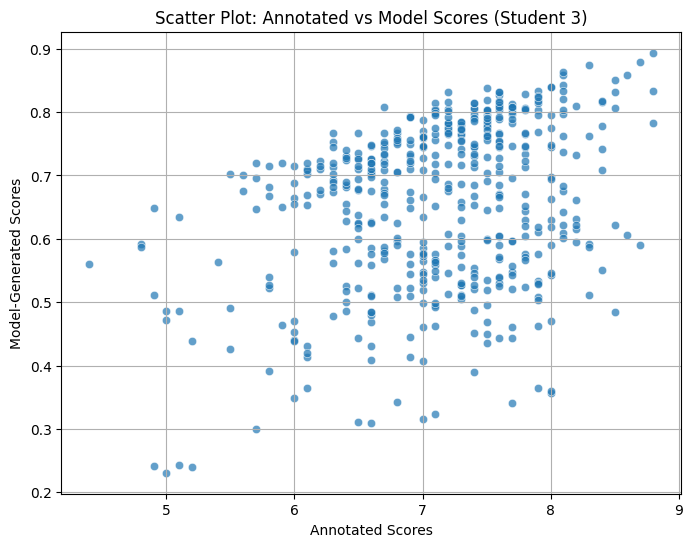

Pearson Correlation for Student 3: 0.3234 (p-value: 0.0000)


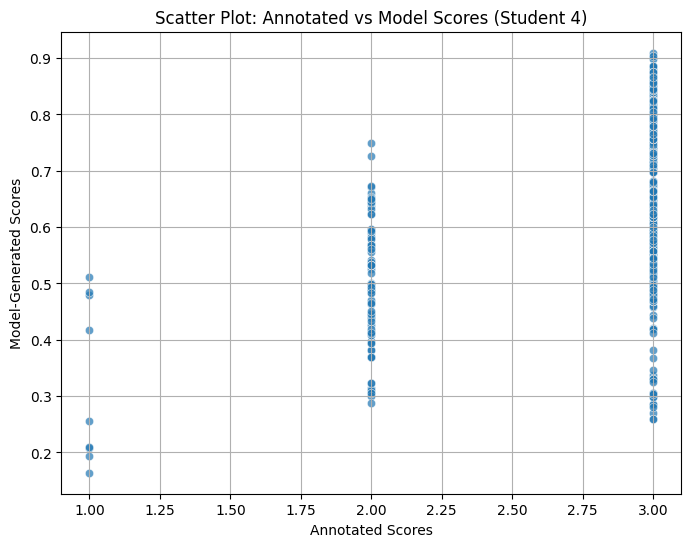

Pearson Correlation for Student 4: 0.4787 (p-value: 0.0000)


In [ ]:
for i in range(1, 5):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=data[f'student_{i}_score'], y=data[f'final_score_{i}'], alpha=0.7)
    plt.title(f"Scatter Plot: Annotated vs Model Scores (Student {i})")
    plt.xlabel("Annotated Scores")
    plt.ylabel("Model-Generated Scores")
    plt.grid(True)
    plt.show()
    correlation, p_value = pearsonr(data[f'student_{i}_score'], data[f'final_score_{i}'])
    print(f"Pearson Correlation for Student {i}: {correlation:.4f} (p-value: {p_value:.4f})")


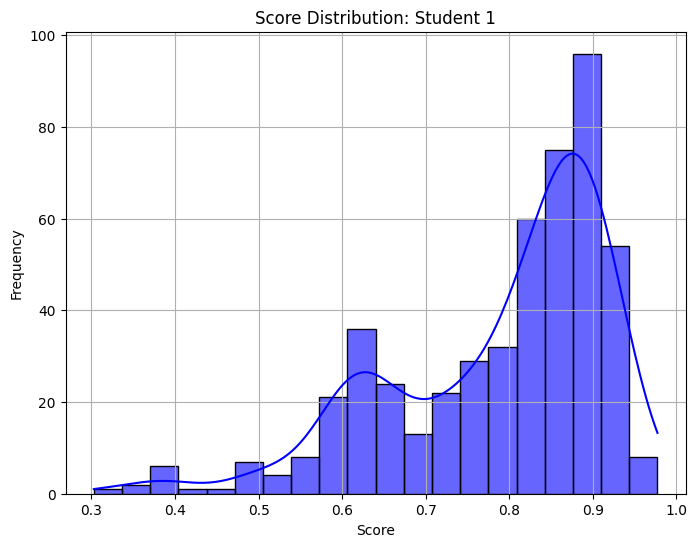

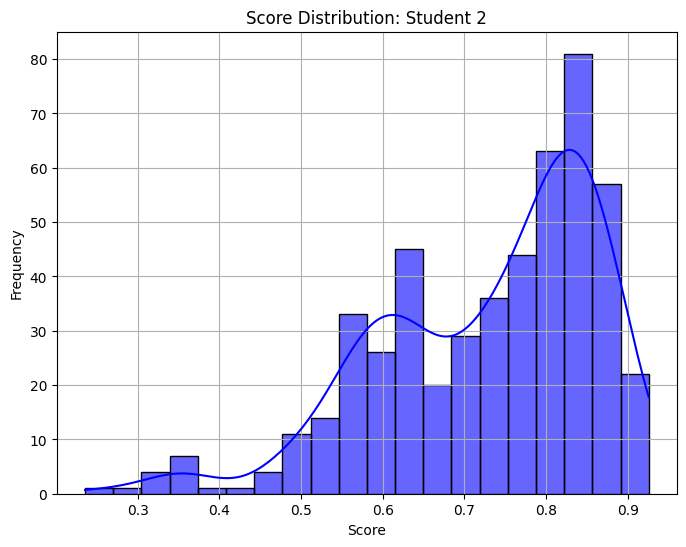

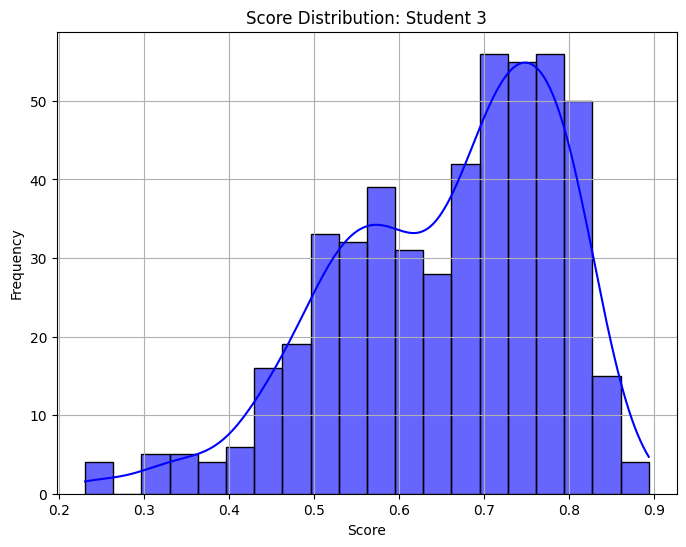

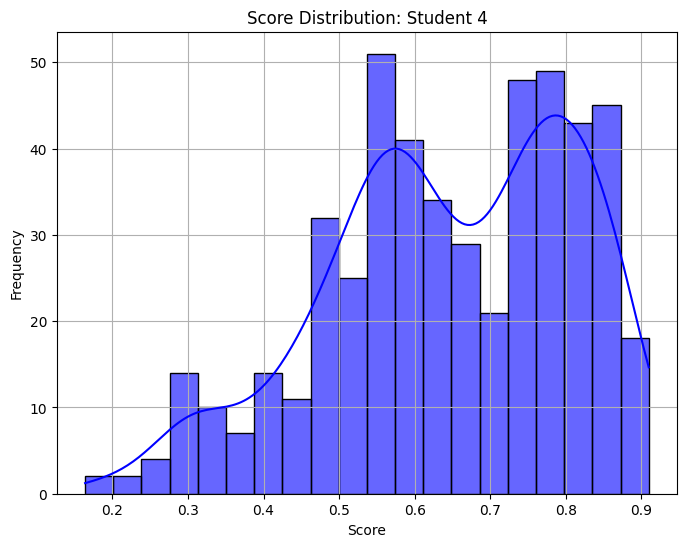

In [ ]:
for i in range(1, 5):
    plt.figure(figsize=(8, 6))
    sns.histplot(data[f'final_score_{i}'], kde=True, bins=20, color='blue', alpha=0.6)
    plt.title(f"Score Distribution: Student {i}")
    plt.xlabel("Score")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()


In [ ]:
# Inputs
question = "What are static variables in C?."
ideal_answer = (
"Static variables retain their value between function calls and have a lifespan equal to the program's execution. They are initialized only once."
)
student_answer = (
   "Static variables retain their value between function calls . They are initialized only once.they use less memmory and efficient"
)

# Preprocess the answers
ideal_cleaned = preprocess_text(ideal_answer)
student_cleaned = preprocess_text(student_answer)

# TF-IDF for the single answer
tfidf_ideal = tfidf_vectorizer.transform([ideal_cleaned])
tfidf_student = tfidf_vectorizer.transform([student_cleaned])

# LDA similarity score
lda_ideal = lda_model.transform(tfidf_ideal)
lda_student = lda_model.transform(tfidf_student)
lda_score = cosine_similarity(lda_ideal, lda_student)[0][0]

# SBERT similarity score
sbert_similarity = cosine_similarity(
    [sbert_model.encode(ideal_answer)],
    [sbert_model.encode(student_answer)]
)[0][0]

# T5 similarity score
t5_input = t5_tokenizer(f"generate answer: {ideal_answer}", return_tensors="pt", padding=True, truncation=True, max_length=512)
with torch.no_grad():
    t5_output = t5_model.generate(input_ids=t5_input['input_ids'], attention_mask=t5_input['attention_mask'])
t5_generated_answer = t5_tokenizer.decode(t5_output[0], skip_special_tokens=True)
t5_similarity = cosine_similarity(
    [sbert_model.encode(t5_generated_answer)],
    [sbert_model.encode(student_answer)]
)[0][0]

# Length penalty for short answers
ideal_length = len(ideal_answer.split())
student_length = len(student_answer.split())
length_ratio = student_length / ideal_length
length_penalty = 1 if length_ratio >= 0.8 else max(0.5, length_ratio)

# Compute final score with length penalty
raw_final_score = (lda_score + sbert_similarity + t5_similarity) / 3
scaled_score = raw_final_score * length_penalty * 10  # Scale to 10-point scale

# Display results
print("Question:", question)
print("Ideal Answer:", ideal_answer)
print("Student Answer:", student_answer)
print("\nScores:")
print(f"LDA Score: {lda_score:.4f}")
print(f"SBERT Score: {sbert_similarity:.4f}")
print(f"T5 Score: {t5_similarity:.4f}")
print(f"Length Penalty: {length_penalty:.2f}")
print(f"Raw Final Score: {raw_final_score:.4f}")
print(f"Scaled Final Score (out of 10): {scaled_score:.2f}")


Question: What are static variables in C?.
Ideal Answer: Static variables retain their value between function calls and have a lifespan equal to the program's execution. They are initialized only once.
Student Answer: Static variables retain their value between function calls . They are initialized only once.they use less memmory and efficient

Scores:
LDA Score: 0.9120
SBERT Score: 0.9215
T5 Score: 0.8083
Length Penalty: 1.00
Raw Final Score: 0.8806
Scaled Final Score (out of 10): 8.81


In [ ]:
import pickle

# Save TfidfVectorizer
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

# Save LDA model
with open('lda_model.pkl', 'wb') as f:
    pickle.dump(lda_model, f)

# Save SentenceTransformer model
sbert_model.save('sbert_model')

# Save T5 model weights
t5_model.save_pretrained("t5-small")

# Save T5 tokenizer
t5_tokenizer.save_pretrained("t5-small")


('t5-small/tokenizer_config.json',
 't5-small/special_tokens_map.json',
 't5-small/spiece.model',
 't5-small/added_tokens.json')

In [ ]:
# prompt: download the saved to local system

from google.colab import files
files.download('tfidf_vectorizer.pkl')
files.download('lda_model.pkl')
!zip -r sbert_model.zip sbert_model
files.download('sbert_model.zip')
!zip -r t5-small.zip t5-small
files.download('t5-small.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  adding: sbert_model/ (stored 0%)
  adding: sbert_model/README.md (deflated 64%)
  adding: sbert_model/1_Pooling/ (stored 0%)
  adding: sbert_model/1_Pooling/config.json (deflated 57%)
  adding: sbert_model/tokenizer.json (deflated 71%)
  adding: sbert_model/vocab.txt (deflated 53%)
  adding: sbert_model/modules.json (deflated 62%)
  adding: sbert_model/config.json (deflated 47%)
  adding: sbert_model/sentence_bert_config.json (deflated 4%)
  adding: sbert_model/tokenizer_config.json (deflated 73%)
  adding: sbert_model/model.safetensors (deflated 9%)
  adding: sbert_model/special_tokens_map.json (deflated 80%)
  adding: sbert_model/2_Normalize/ (stored 0%)
  adding: sbert_model/config_sentence_transformers.json (deflated 34%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  adding: t5-small/ (stored 0%)
  adding: t5-small/spiece.model (deflated 48%)
  adding: t5-small/added_tokens.json (deflated 83%)
  adding: t5-small/generation_config.json (deflated 29%)
  adding: t5-small/config.json (deflated 62%)
  adding: t5-small/tokenizer_config.json (deflated 94%)
  adding: t5-small/model.safetensors (deflated 53%)
  adding: t5-small/special_tokens_map.json (deflated 85%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>